# Reconnaissance des panneaux de signalisation routière
GIF-4001, GIF-7005 – Introduction à l'apprentissage automatique : Projet

Jade Clouâtre – Isabelle Eysseric – Damien LaRocque – Benoit Verret

## Imports

In [1]:
from os import listdir, mkdir
from time import time
from glob import glob
from copy import deepcopy
from pprint import pprint, pformat
from typing import List, Tuple, Union, Dict
from zipfile import ZipFile
from pathlib import PurePath
from os.path import isdir
from requests import Response, get
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.optim import SGD, lr_scheduler
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
from torchvision.datasets import ImageFolder

from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# If use outside a notebook use :
# from tqdm import tqdm, trange
# instead of :
from tqdm.notebook import tqdm, tnrange as trange

## Déclaration des constantes

In [2]:
DATASET_URL: str = "https://github.com/GIF4101-GIF7005-Projet/traffic-sign-detector/raw/master/GTSRBSelection.zip"
DATASET_URL_QC: str = "https://github.com/GIF4101-GIF7005-Projet/traffic-sign-detector/raw/master/Donnees_Quebec.zip"

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
IS_COLAB_ENV: bool = False

NUM_CLASSES: int = 43
NUM_CLASSES_QC: int = 25

SHUFFLE: bool = True
NUM_WORKER: int = 4
BATCH_SIZE: int = 32

# Transformation values
RESIZE_VALUE: int = 256
CROP_VALUE: int = 224
ROTATION_VALUE: int = 15
STD_VALS: List[int]  = [int(0.229 * 255), int(0.224 * 255), int(0.225 * 255)]
MEAN_VALS: List[int] = [int(0.485 * 255), int(0.456 * 255), int(0.406 * 255)]

NB_EPOCH: int = 5
MOMENTUM: float = 0.9
LEARNING_RATE: float = 0.01

## Fonctions utilitaires

In [3]:
def download_dataset(dataset_url: str, zip_name: str):
    """Download Dataset

    Download zipped dataset and unzipped it

    Parameters
    ----------
    dataset_url : str
        Dataset source URL
    zip_name : str
        Dataset zip filename destination
    """
    res: Response = get(url=dataset_url, stream=True)

    if res.status_code == 200:
        with open(f"{zip_name}.zip", "wb") as handle:
            for chunk in tqdm(
                [c for c in res.iter_content(chunk_size=512)], desc=f"Download {zip_name} Dataset"
            ):
                if chunk:
                    handle.write(chunk)
    else:
        res.raise_for_status()
    with ZipFile(f"{zip_name}.zip") as zipd:
        zipd.extractall()

def breakpoint():
    """Python Debugger

    Debug breakpoint functionnality for Python 3.6
    """
    import pdb; pdb.set_trace()

## Fonctions d'affichage

In [4]:
def bar_plot_train_test_accuracy_by_classe_id(train_accuracy, test_accuracy, prefix: str =""):
    """Bar Plot illustrating Train and Test accuracy by Classe Id

    Parameters
    ----------
    train_accuracy : ArrayLike
        Train accuracy value by Classe Id
    test_accuracy : ArrayLike
        Train accuracy value by Classe Id
    prefix : str
        filename prefix

    Raises
    ------
    AssertionError
        Train and Test accuracy should have the same lenght.
    """
    assert len(train_accuracy) == len(test_accuracy), "Train and Test accuracy should have the same lenght, Train={len(train_accuracy)}, Test={len(test_accuracy)}"
    labels = list(range(len(train_accuracy)))

    x = np.arange(len(labels)) # the label locations
    width = 0.35 # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(30, 12)

    train = ax.bar(x - width/2, train_accuracy, width, label='Train')
    test = ax.bar(x + width/2, test_accuracy, width, label='Test')

    ax.set_ylabel('Accuracy', fontsize="x-large")
    ax.set_xlabel('Classe Id', fontsize="x-large")
    ax.set_title('Accuracy per Classe Id', fontsize="x-large")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(fontsize="x-large")

    fig.tight_layout()
    plt.savefig(f"{prefix+'_' if prefix else prefix}bar_plot_train_test_accuracy_by_classe_id.png", bbox_inches='tight')
    plt.show()

def bar_plot_accuracy_by_classe_id(accuracy, legend, prefix: str =""):
    """Bar Plot illustrating Accuracy by Classe Id

    Parameters
    ----------
    accuracy : ArrayLike
        Accuracy value by Classe Id
    legend : str
        Legend for the accuracy elements
    prefix : str
        filename prefix
    """
    labels = list(range(0, len(accuracy)))

    x = np.arange(len(labels)) # the label locations
    width = 0.70 # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 12)

    acc = ax.bar(x, accuracy, width, label=legend)

    ax.set_ylabel('Accuracy', fontsize="x-large")
    ax.set_xlabel('Classe Id', fontsize="x-large")
    ax.set_title('Accuracy per Classe Id', fontsize="x-large")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(fontsize="x-large")

    fig.tight_layout()
    plt.savefig(f"{prefix+'_' if prefix else prefix}bar_plot_{legend.lower()}_accuracy_by_classe_id.png", bbox_inches='tight')
    plt.show()

def hist_plot_dist_data_in_trainset(train_set, nb_classes: int = 43, prefix: str =""):
    """Histrogramme Plot illustrating Training Data by Classe Id

    Parameters
    ----------
    train_set : Dataset
        Training Dataset
    nb_classes : int
       Number of Classe
    prefix : str
        filename prefix
    """
    labels = list(range(nb_classes+1))

    x = np.arange(len(labels)) # the label locations
    width = 0.8 # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 12)
    acc = ax.hist(train_set.__targets, bins=labels, align="left", rwidth=width)

    ax.set_ylabel('nb data', fontsize="x-large")
    ax.set_xlabel('Classe Id', fontsize="x-large")
    ax.set_title('Visualisation de la distribution des données dans le `train_set`', fontsize="x-large")
    ax.set_xticks(x[:-1])
    ax.set_xticklabels(labels[:-1])

    fig.tight_layout()
    plt.savefig(f"{prefix+'_' if prefix else prefix}hist_plot_dist_data_in_trainset.png", bbox_inches='tight')
    plt.show()

def plot_loss_by_epoch(train_loss, val_loss, prefix: str =""):
    """Plot illustrating Loss by Epoch

    Parameters
    ----------
    train_loss : ArrayLike
        Training loss per epoch
    val_loss : ArrayLike
        Validation loss per epoch
    prefix : str
        filename prefix
    """
    epoch = list(range(1, len(train_loss)+1))

    x = np.arange(len(epoch)) # the label locations

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 12)
    acc = ax.plot(x, train_loss, color='b', label="Train loss")
    acc = ax.plot(x, val_loss, color='g', label="Val loss")

    ax.set_ylabel('Loss', fontsize="x-large")
    ax.set_xlabel('Epoch #', fontsize="x-large")
    ax.set_title('Loss', fontsize="x-large")
    ax.set_xticks(x)
    ax.set_xticklabels(epoch)
    ax.legend(fontsize="x-large")

    fig.tight_layout()
    plt.savefig(f"{prefix+'_' if prefix else prefix}plot_loss_by_epoch.png", bbox_inches='tight')
    plt.show()

def plot_accuracy_by_epoch(train_accuracy, val_accuracy, prefix: str =""):
    """Plot illustrating Accuracy by Epoch

    Parameters
    ----------
    train_accuracy : ArrayLike
        Training accuracy per epoch
    val_accuracy : ArrayLike
        Validation accuracy per epoch
    prefix : str
        filename prefix
    """
    epoch = list(range(1, len(train_accuracy)+1))

    x = np.arange(len(epoch)) # the label locations

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 12)
    acc = ax.plot(x, train_accuracy, label="Train accuracy", color="b")
    acc = ax.plot(x, val_accuracy, label="Val accuracy", color="g")

    ax.set_ylabel('Accuracy', fontsize="x-large")
    ax.set_xlabel('Epoch #', fontsize="x-large")
    ax.set_title('Accuracy', fontsize="x-large")
    ax.set_xticks(x)
    ax.set_xticklabels(epoch)
    ax.legend(fontsize="x-large")

    fig.tight_layout()
    plt.savefig(f"{prefix+'_' if prefix else prefix}plot_accuracy_by_epoch.png", bbox_inches='tight')
    plt.show()

def plot_statistics(stats: Dict, prefix: str =""):
    """Plot illustrating Validation and Accuracy by Epoch

    Parameters
    ----------
    stats : Dict
        Model's statistics 
    prefix : str
        filename prefix
    """
    fig, subfigs = plt.subplots(1, 2)

    epoch = list(range(1, len(stats["losses"]["val"])+1))
    x = np.arange(len(epoch))

    for ax, datatype in zip(subfigs, stats.keys()):
        ax.plot(x, stats[datatype]["train"], label=f"Training {datatype}")
        ax.plot(x, stats[datatype]["val"], label=f"Validation {datatype}")

        ax.legend()
        ax.set_xlabel("Epochs")
        ax.set_title(f"{datatype[0].upper()+datatype[1:]} Training & Validation by Epoch")

    fig.tight_layout()
    plt.savefig(f"{prefix+'_' if prefix else prefix}plot_statistic.png", bbox_inches='tight')
    plt.show()

def bar_plot_report(values: dict, comptype: str, transfer: bool=False):
    """Bar plot illustrating comparaison between two elements

    Parameters
    ----------
    values : Dict
        Statistique values
    comptype : str
        Comparator type
    transfer : bool
        If plot for transfer learning, by default False
    """
    fig, ax1 = plt.subplots()

    support = values["support"]
    x = np.arange(len(support))
    y = values[comptype]

    fig.set_size_inches(20, 12)

    w = 0.2
    color = 'b'
    ax1.bar(x-w, support, width=w, color=color, align='edge', label="N° données entraînement")
    ax1.set_ylabel(f"N° de données\nd'entraînement", fontsize="x-large", color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(np.arange(len(support)))

    ax2 = ax1.twinx()
    color = 'r'
    ax2.bar(x, y, width=w, color=color, align='edge', label=comptype.title())
    ax2.set_ylabel(f"{comptype.title()}", fontsize="x-large", color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([0, 1.5])

    ax1.set_xlabel(f"N° de classe", fontsize="x-large")
    ax1.set_title(f"{comptype.title()} et nombre de\ndonnées de support pour chaque classe", fontsize="x-large")
    bar1, lab1 = ax1.get_legend_handles_labels()
    bar2, lab2 = ax2.get_legend_handles_labels()
    ax1.legend(bar1 + bar2, lab1 + lab2, fontsize="x-large")

    fig.tight_layout()
    fig.savefig(f"{'tf-' if transfer else ''}report-{comptype}-bar.png", bbox_inches='tight')
    plt.show()

## Développement du modèle

In [5]:
class TrafficSignModel(nn.Module):
    """Traffic Sign Model

    Neural network model, define and initialize the layers of the network.
    """

    def __init__(self):
        super().__init__()
        # Initialisation des modules contenant des paramètres à optimiser. 
        self.C1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, bias=False)
        self.N2 = nn.BatchNorm2d(32)
        
        self.C3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, bias=False)
        self.N4 = nn.BatchNorm2d(64)
        
        self.C5 = nn.Conv2d(64, 64, kernel_size=3, stride=2, bias=False)
        self.N6 = nn.BatchNorm2d(64)
        
        self.C7 = nn.Conv2d(64, 64, kernel_size=3, stride=2, bias=False)
        self.N8 = nn.BatchNorm2d(64)
        
        self.C9 = nn.Conv2d(64, 64, kernel_size=3, stride=2, bias=False)
        self.N10 = nn.BatchNorm2d(64)
        
        self.L11 = nn.Linear(64, NUM_CLASSES)
        self.output = nn.Sigmoid()

    def forward(self, x):
        """Forward

        Control in which order the inference will be done on the layers.
        """
        y = F.relu(self.N2(self.C1(x)))
        y = F.relu(self.N4(self.C3(y)))
        y = F.relu(self.N6(self.C5(y)))
        y = F.relu(self.N8(self.C7(y)))
        y = F.relu(self.N10(self.C9(y)))
        
        y = y.view(y.size()[0], 64, -1).mean(dim=2)
        y = self.L11(y)

        return self.output(y)

def load_model(filename: Union[str,PurePath]) -> Tuple[nn.Module, optim.Optimizer, nn.Module, Dict]:
    """Model Loader

    Allow to load a previously saved model

    Parameters
    ----------
    filename : Union[str,PurePath]
        Model filename

    Returns
    -------
    Tuple[nn.Module, optim.Optimizer, nn.Module, Dict]
        Return the model, the optimizer, the criterion and the statistics
    """
    data = torch.load(str(PurePath(f"models/{filename}.plt")), map_location='cpu')

    model: nn.Module = data['model']
    model.load_state_dict(data['model_state'])
    optimizer: optim.Optimizer = data['optimizer']
    optimizer.load_state_dict(data['optimizer_state'])
    criterion: nn.Module = data['criterion']
    criterion.load_state_dict(data['criterion_state'])
    stats: dict = data['stats']

    return model, optimizer, criterion, stats

def predict(model, test_data_loader, device):
    """Model prediction

    Generate prediction for a given Model

    Parameters
    ----------
    model :
        Network Model
    test_data_loader :
        Test Dataloader
    device :
        Device to allow GPU or CPU computing

    Returns
    -------
    Tuple
        Predictions and targets.
    """
    model = model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, labels in test_data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)


            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            predictions.extend(preds)
            targets.extend(labels)

    predictions = torch.as_tensor(predictions).cpu()
    targets = torch.as_tensor(targets).cpu()
    return predictions, targets

## Entraînement du modele

In [6]:
class Trainer:
    """Model's Trainer

    Parameters
    ----------
    model : nn.Module
        Network Model
    data_loaders : Dict
        Dictionnary with the differents DataLoader
    device :
        Device to allow GPU or CPU computing
    n_epochs : int
        Number of Epoch, by default 25
    lr : float
        Learning rate, by default 0.001
    momentum : float
        Momemtum, by default 0.9
    """
    def __init__(self, model: nn.Module, data_loaders: dict, device=None, n_epochs: int=25, lr=0.001, momentum=0.9):
        self.model = self.create_model() if model is None else model
        self.optimizer = SGD(self.model.parameters(), lr=lr, momentum=momentum)
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=7, gamma=0.1)
        self.criterion = nn.CrossEntropyLoss()
        self.data_loaders = data_loaders
        self.n_epochs = n_epochs
        self.device=device

        self.train_losses = list()
        self.val_losses = list()
        self.train_accuracies = list()
        self.val_accuracies = list()

    def create_model(self):
        """Model creator

        Returns
        -------
        nn.Module
            Network Model
        """
        model = models.resnet34(pretrained=True)
        n_features = model.fc.in_features
        model.fc = nn.Linear(n_features, NUM_CLASSES)
        return model

    def save_model(self):
        """Save Model

        Save a model for further use

        Returns
        -------
        PurePath
            Destination path
        """
        model_name = self.model.__class__.__name__
        timestamp = time()
        path = PurePath(f"models/{model_name}_{timestamp}.plt")

        data = {
            'model': self.model.cpu(),
            'model_state': self.model.state_dict(),
            'optimizer': self.optimizer,
            'optimizer_state': self.optimizer.state_dict(),
            'criterion': self.criterion.cpu(),
            'criterion_state': self.criterion.state_dict(),
            'stats': self.get_stats()
        }
        torch.save(data, f"{path}")
        print(f"Saved model at {path}")
        return path

    def train_epoch(self, model, pbar):
        """Training for a specific Epoch

        Show accuracy and loss evolution during batch iteration

        Parameters
        ----------
        model :
            Trained model
        pbar :
            Tqdm progression bar for visualisation

        Returns
        -------
        Tuple
            Model, Train loss and Train accuracy for this Epoch
        """
        train_data_loader = self.data_loaders["train"]

        cumul_loss = list()
        cumul_corr = 0

        for i_batch, (images, targets) in enumerate(train_data_loader):
            tqdm.write(f' [-] Batch: {i_batch+1:4}/{len(train_data_loader)}, '
                f'Train loss: {np.mean(cumul_loss or 0):.4f}, '
                f'Train accuracy: {(cumul_corr.double() if cumul_corr else 0) / len(train_data_loader.dataset):.4%}',
                end="")
            images = images.to(self.device)
            targets = targets.long().to(self.device)

            # Forward
            outputs = model(images.float())
            _, preds = torch.max(outputs, dim=1)
            loss = self.criterion(outputs, targets)

            # statistics
            cumul_loss.append(loss.item())
            cumul_corr += torch.sum(preds == targets)

            # backward
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            pbar.update(1)

        self.scheduler.step()

        epoch_loss = np.mean(cumul_loss)
        epoch_acc = cumul_corr.double() / len(train_data_loader.dataset)
        tqdm.write(f' [-] Batch: {len(train_data_loader):4}, '
            f'Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4%}')

        return model, epoch_loss, epoch_acc


    def get_model(self):
        """Model Getter

        Returns
        -------
            Model
        """
        return self.model

    def get_stats(self):
        """Statistics Getter

        Get losses and accuracies statistics for train and validation

        Returns
        -------
        Dict
            Train and validation statistics
        """
        return {
                   "losses": {"train": self.train_losses, "val": self.val_losses}, 
                   "accuracies": {"train": self.train_accuracies, "val": self.val_accuracies}
               }

    def validate_epoch(self, model, pbar):
        """Validation for a specific Epoch

        Show accuracy and loss evolution during batch iteration

        Parameters
        ----------
        model :
            Validation model
        pbar :
            Tqdm progression bar for visualisation

        Returns
        -------
        Tuple
            Model, Validation loss and Validation accuracy for this Epoch
        """
        val_data_loader = self.data_loaders["val"]

        cumul_loss = list()
        cumul_corr = 0

        with torch.no_grad():
            for i_batch, (images, targets) in enumerate(val_data_loader):
                tqdm.write(f' [-] Batch: {i_batch+1:4}/{len(val_data_loader)},    '
                    f'Val loss: {np.mean(cumul_loss or 0):.4f},   '
                    f'Val accuracy: {(cumul_corr.double() if cumul_corr else 0) / len(val_data_loader.dataset):.4%}',
                    end="")
                images = images.to(self.device)
                targets = targets.long().to(self.device)

                # Forward
                outputs = model(images.float())
                _, preds = torch.max(outputs, dim=1)
                loss = self.criterion(outputs, targets)

                # statistics
                cumul_loss.append(loss.item())
                cumul_corr += torch.sum(preds == targets)

                pbar.update(1)

        epoch_loss = np.mean(cumul_loss)
        epoch_acc = cumul_corr.double() / len(val_data_loader.dataset)
        tqdm.write(f' [-] Batch: {len(val_data_loader):4},   '
            f'Val loss: {epoch_loss:.4f},   Val accuracy: {epoch_acc:.4%}')

        return model, epoch_loss, epoch_acc


    def train(self, lr: float=0.01):
        """Training

        Train model and validation

        Parameters
        ----------
        lr : int
            Learning rate, by default 0.01
        """
        model = self.model
        
        train_losses = list()
        val_losses = list()

        train_accuracies = list()
        val_accuracies = list()

        best_model = deepcopy(model.state_dict())
        best_acc = 0.0

        if torch.cuda.is_available():
            model = model.cuda()
            self.criterion = self.criterion.cuda()

        time_length = self.n_epochs * (1 + len(self.data_loaders["train"]) + len(self.data_loaders["val"]))
        with tqdm(total=time_length, desc="Training...") as progress_bar:
            for epoch in range(self.n_epochs):
                tqdm.write(f"\nEpoch {epoch + 1:2}/{self.n_epochs}")
                tqdm.write("-" * 11)

                progress_bar.update(1)

                model = model.train()
                model, train_loss, train_acc = self.train_epoch(model, pbar=progress_bar)
                train_losses.append(train_loss)
                train_accuracies.append(train_acc.detach().cpu().numpy())

                progress_bar.update(1)

                model = model.eval()
                model, val_loss, val_acc = self.validate_epoch(model, pbar=progress_bar)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc.detach().cpu().numpy())

                if val_acc > best_acc:
                    best_acc = val_acc
                    best_model = deepcopy(model.state_dict())

        model.load_state_dict(best_model)
        self.model = model.cpu()
        self.train_losses = train_losses
        self.val_losses = val_losses
        self.train_accuracies = train_accuracies
        self.val_accuracies = val_accuracies

## Programme de détection de panneaux de signalisation

In [7]:
def main():
    """Main program

    Traffic sign recognition program
    """
    print("Exécution de l'entrainement de détection de panneaux de signalisation allemand")
    # Download Dataset
    if not isdir("GTSRBSelection"):
        download_dataset(DATASET_URL, "GTSRBSelection")
    if not isdir("models"):
        mkdir("models")

    # Create Tranform Compose
    transforms = dict(
        train=T.Compose([
            T.Resize(size=RESIZE_VALUE),
            T.RandomResizedCrop(size=CROP_VALUE),
            T.RandomRotation(degrees=ROTATION_VALUE),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize(MEAN_VALS, STD_VALS),
        ]),
        val=T.Compose([
            T.Resize(size=RESIZE_VALUE),
            T.CenterCrop(size=CROP_VALUE),
            T.ToTensor(),
            T.Normalize(MEAN_VALS, STD_VALS),
        ]),
        test=T.Compose([
            T.Resize(size=RESIZE_VALUE),
            T.CenterCrop(size=CROP_VALUE),
            T.ToTensor(),
            T.Normalize(MEAN_VALS, STD_VALS),
        ])
    )

    # Image folder
    dataset = ImageFolder("GTSRBSelection")
    dataset_sizes = [int(len(dataset) * a) for a in [0.75, 0.15]]
    dataset_sizes.extend([len(dataset) - sum(dataset_sizes)])
    train_set, val_set, test_set = random_split(dataset, dataset_sizes)

    # Apply Transforms on datasets
    train_set.dataset.transform = transforms["train"]
    val_set.dataset.transform = transforms["val"]
    test_set.dataset.transform = transforms["test"]

    data_loaders = dict(
        train=DataLoader(train_set,batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKER),
        val=DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKER),
        test=DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKER)
    )

    # Entrainement du model
    trainer = Trainer(model=None, data_loaders=data_loaders, device=DEVICE, n_epochs=NB_EPOCH)   
    trainer.train()
    trainer.save_model()
    stats = trainer.get_stats()

    return stats, trainer, data_loaders

## Exécution du programme

Exécution de l'entrainement de détection de panneaux de signalisation allemand


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



Epoch  1/5
-----------
 [-] Batch:  279, Train loss: 0.3210, Train accuracy: 91.9632%
 [-] Batch:   56,   Val loss: 0.5027,   Val accuracy: 83.8855%

Epoch  2/5
-----------
 [-] Batch:  279, Train loss: 0.0135, Train accuracy: 99.7755%
 [-] Batch:   56,   Val loss: 0.1913,   Val accuracy: 94.5536%

Epoch  3/5
-----------
 [-] Batch:  279, Train loss: 0.0050, Train accuracy: 99.9327%
 [-] Batch:   56,   Val loss: 0.0138,   Val accuracy: 99.6631%

Epoch  4/5
-----------
 [-] Batch:  279, Train loss: 0.0034, Train accuracy: 99.9663%
 [-] Batch:   56,   Val loss: 0.0036,   Val accuracy: 99.9439%

Epoch  5/5
-----------
 [-] Batch:  279, Train loss: 0.0055, Train accuracy: 99.8990%
 [-] Batch:   56,   Val loss: 0.1777,   Val accuracy: 94.7782%

Saved model at models/ResNet_1608512443.7087638.plt
{'accuracies': {'train': [array(0.91963183),
                          array(0.99775508),
                          array(0.99932652),
                          array(0.99966326),
                 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Représentation du traitement des données


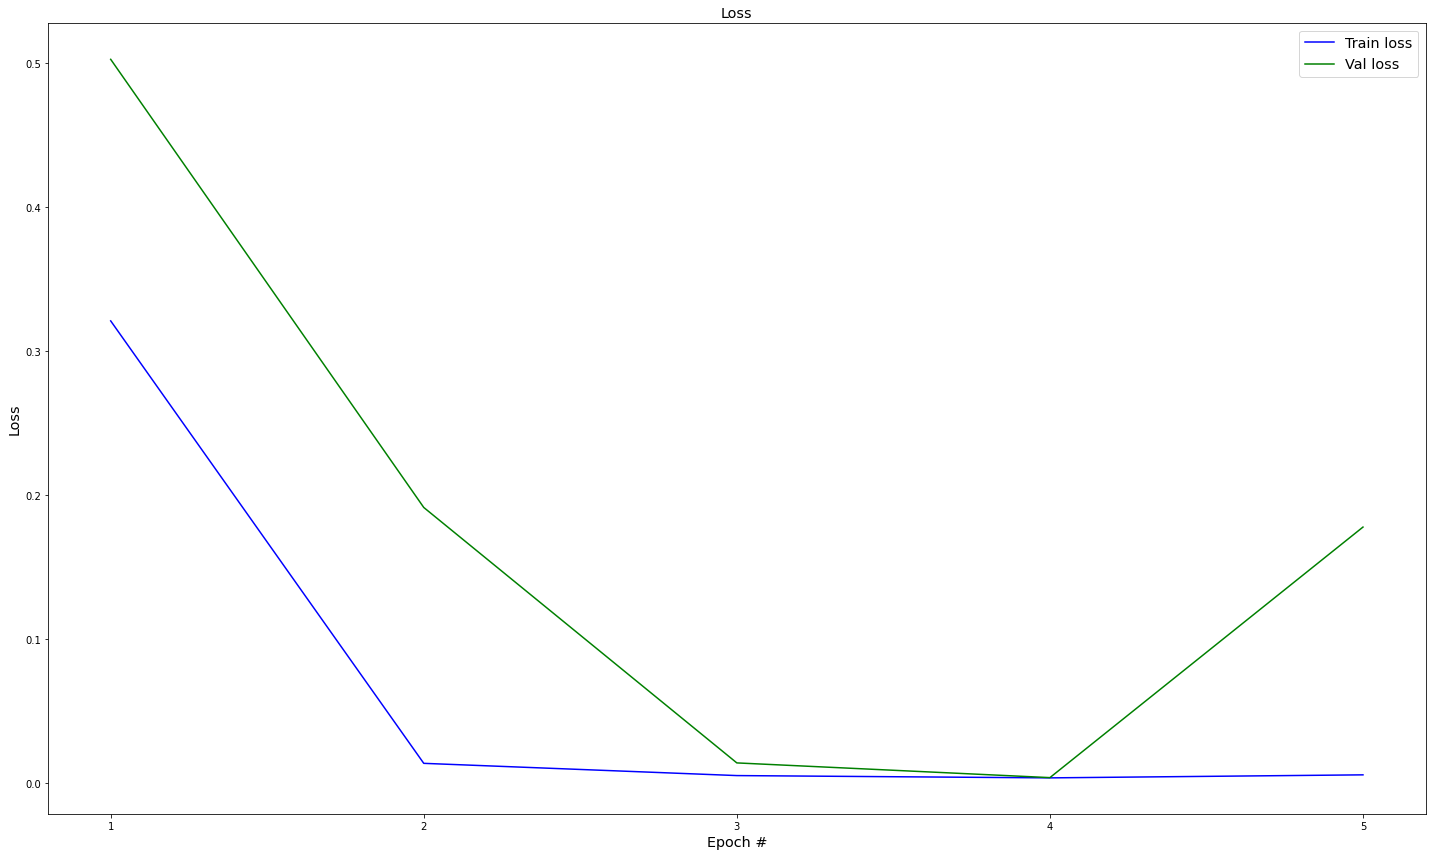

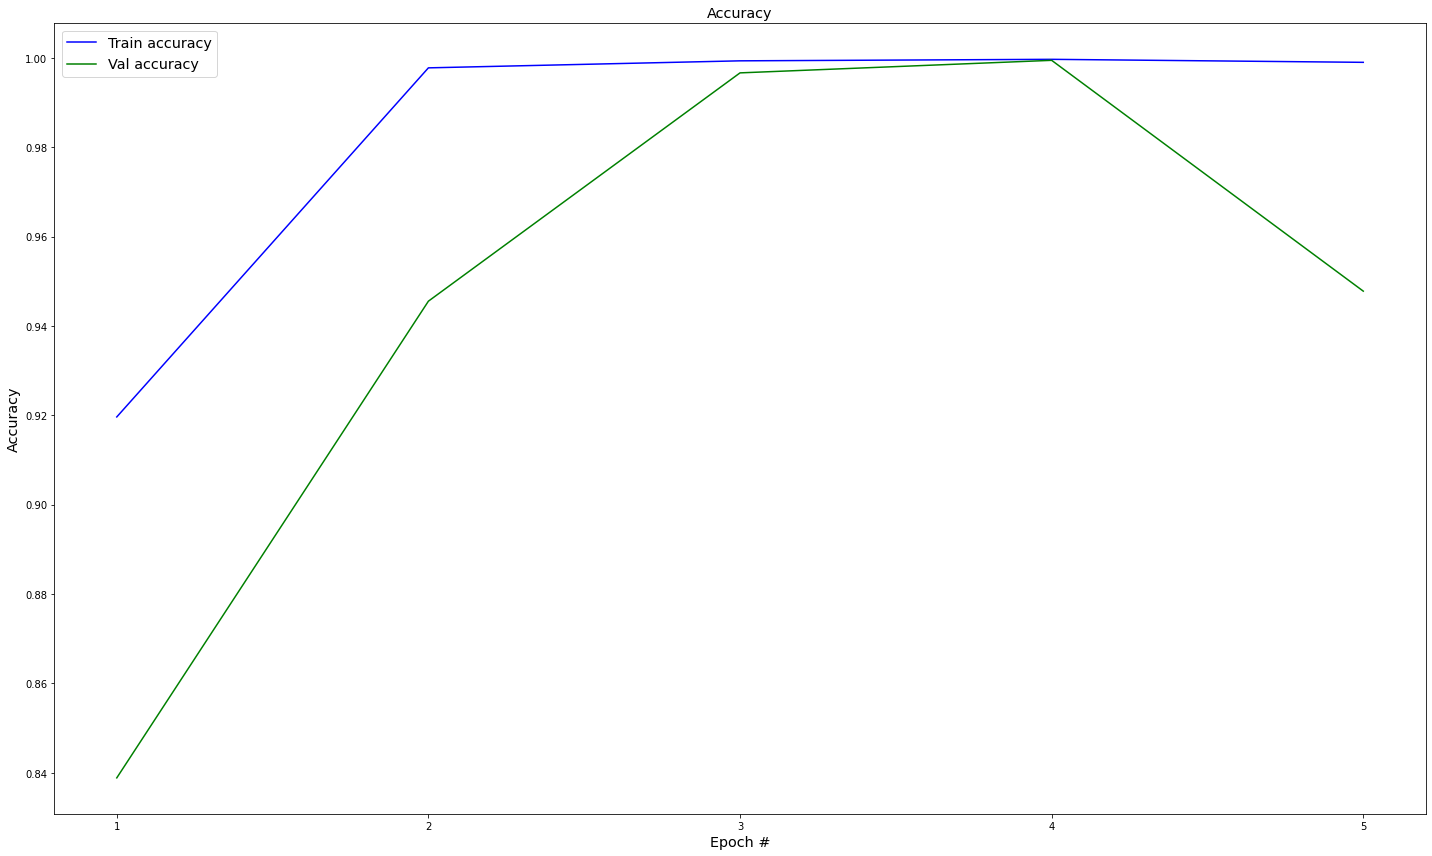

In [8]:
if __name__ == '__main__':
    # Execute program and empty GPU cache
    try:
        stats_de, trainer_de, dldrs_de = main()
        print(pformat(trainer_de.get_stats()))

        try:
            # Only if in a Google Colab Environment
            from google.colab import files
            print("Récupération des données")
            IS_COLAB_ENV = True
            for model_name in listdir("models"):
                files.download(f'/content/models/{model_name}')
        except:
            # Outside Google Colab Environement
            pass

        print("Représentation du traitement des données")
        plot_loss_by_epoch(stats_de["losses"]["train"], stats_de["losses"]["val"])
        plot_accuracy_by_epoch(stats_de["accuracies"]["train"], stats_de["accuracies"]["val"])
        torch.cuda.empty_cache()
    except BaseException as err:
        torch.cuda.empty_cache()
        raise err

## Test du réseau sur les données allemandes

In [9]:
def deutsch_network_test(trainer, data_loaders):
    """Deutsch Network Test

    Process Test with Deustch Model Network
    """
    print("Test du réseau sur les données allemandes")
    dev = trainer.device
    de_model = trainer.get_model().to(dev)

    y_pred, y_test = predict(de_model, data_loaders['test'], dev)
    y_pred = y_pred.float()
    y_test = y_test.float()
    report = precision_recall_fscore_support(y_test, y_pred)

    return report

Test du réseau sur les données allemandes
(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([138, 140, 221, 220,  61, 110, 112,  65,  72,  50]))
Représentation du traitement des données


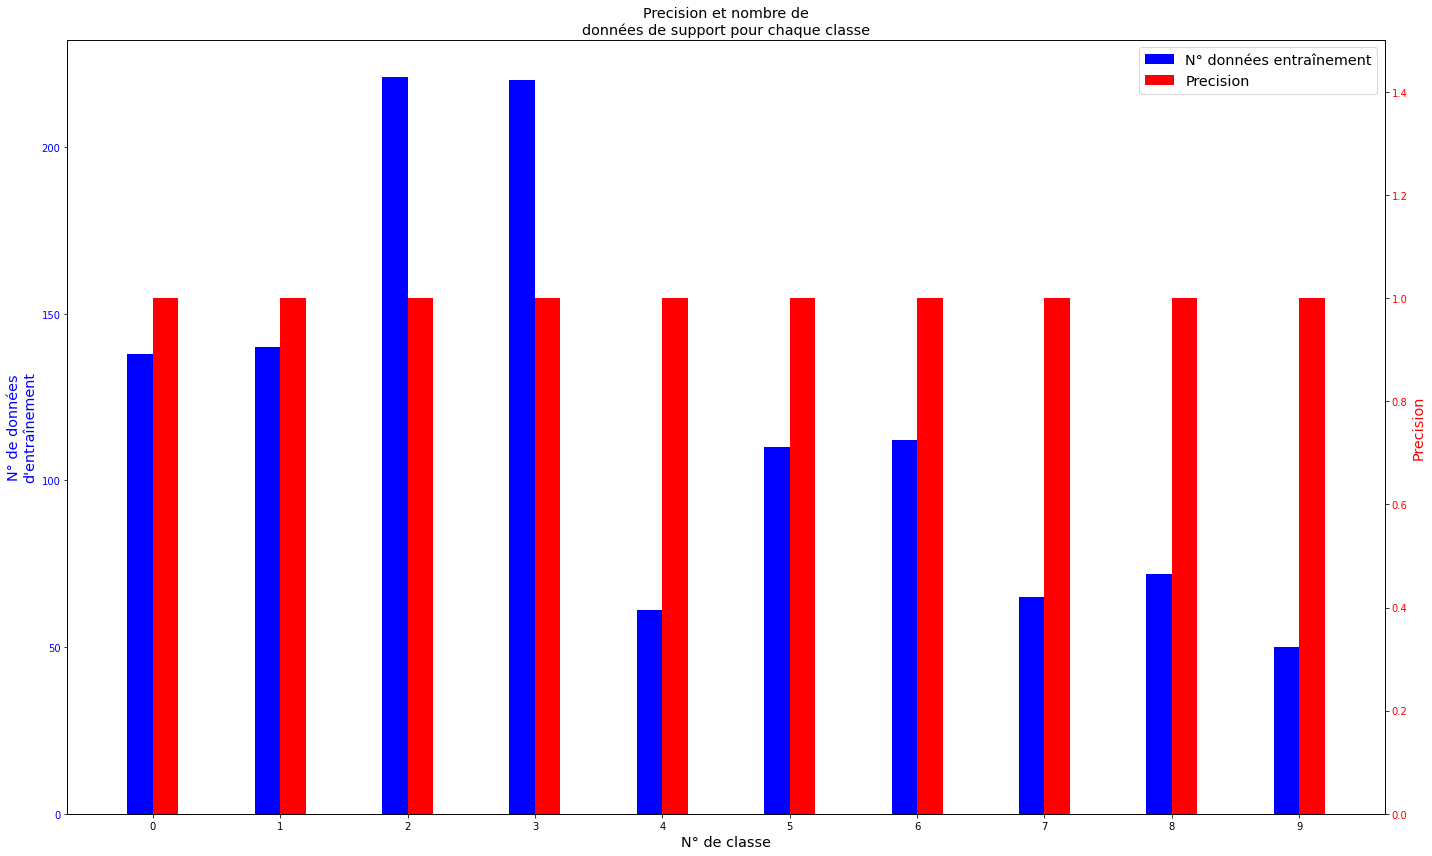

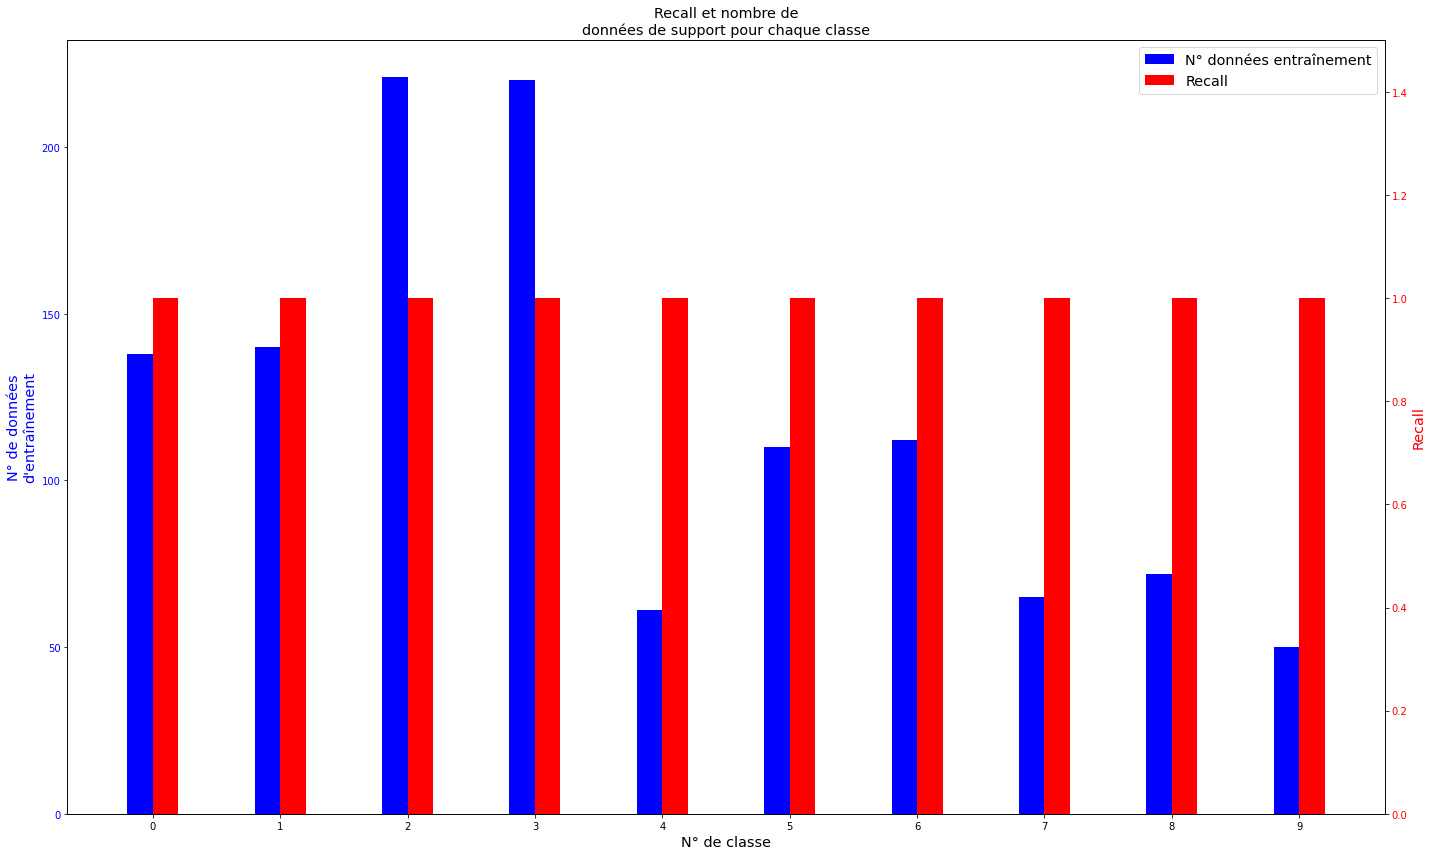

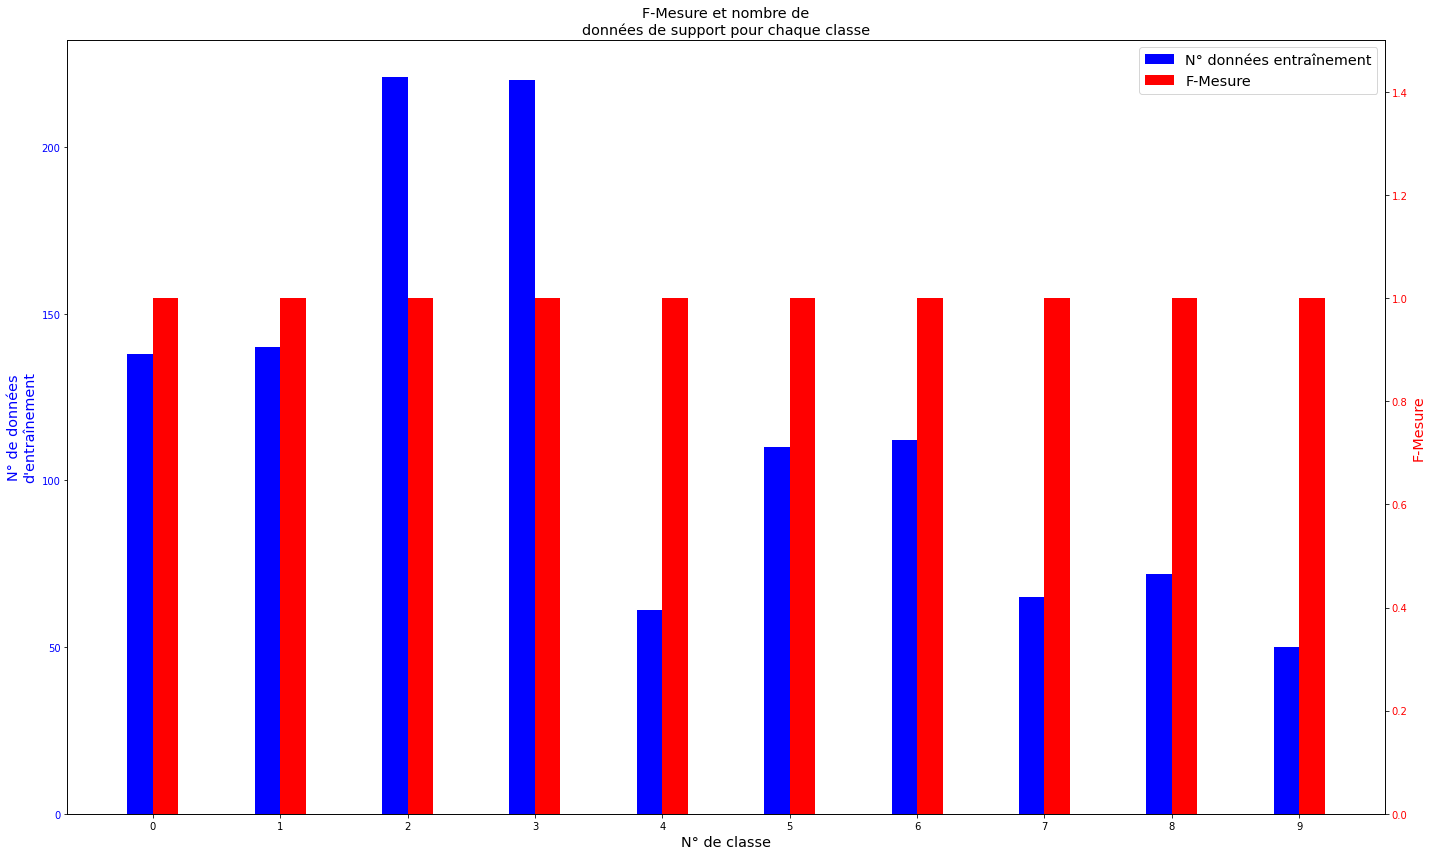

Sauvegarde des images


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
if __name__ == '__main__':
    # Execute program and empty GPU cache
    try:
        report_de = deutsch_network_test(trainer_de, dldrs_de)
        print(pformat(report_de))
        report_vals = {k: v for k, v in zip(("precision", "recall", "f-mesure", "support"), report_de)}
        print("Représentation du traitement des données")
        for c in ("precision", "recall", "f-mesure"):
            bar_plot_report(report_vals, c)
        if IS_COLAB_ENV:
            print("Sauvegarde des images")
            # Only if in a Google Colab Environment
            for img_name in glob("./*.png"):
                files.download(img_name)
        torch.cuda.empty_cache()
    except BaseException as err:
        torch.cuda.empty_cache()
        raise err

## Transfer Learning / Apprentissage par transfert

In [11]:
def main_transfer(trainer):
    """Transfer program

    Traffic sign recognition transfer program to Quebec sign
    """
    print("Transfer Learning / Apprentissage par transfère")
    model_de = trainer.get_model()
    model_qc = deepcopy(model_de)

    # Get Data from Quebec
    # Download Dataset
    if not isdir("Donnees_Quebec"):
        download_dataset(DATASET_URL_QC, "Donnees_Quebec")
    if not isdir("models"):
        mkdir("models")

    # Create Tranform Compose
    transforms = dict(
        train=T.Compose([
            T.Resize(size=RESIZE_VALUE),
            T.RandomResizedCrop(size=CROP_VALUE),
            T.RandomRotation(degrees=ROTATION_VALUE),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize(MEAN_VALS, STD_VALS),
        ]),
        val=T.Compose([
            T.Resize(size=RESIZE_VALUE),
            T.CenterCrop(size=CROP_VALUE),
            T.ToTensor(),
            T.Normalize(MEAN_VALS, STD_VALS),
        ]),
        test=T.Compose([
            T.Resize(size=RESIZE_VALUE),
            T.CenterCrop(size=CROP_VALUE),
            T.ToTensor(),
            T.Normalize(MEAN_VALS, STD_VALS),
        ])
    )

    # Image folder
    dataset = ImageFolder("Donnees_Quebec")
    dataset_sizes = [int(len(dataset) * a) for a in [0.75, 0.15]]
    dataset_sizes.extend([len(dataset) - sum(dataset_sizes)])
    train_set, val_set, test_set = random_split(dataset, dataset_sizes)

    train_set.dataset.transform = transforms["train"]
    val_set.dataset.transform = transforms["val"]
    test_set.dataset.transform = transforms["test"]

    data_loaders = dict(
        train=DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKER),
        val=DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKER),
        test=DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKER)
    )

    # Dernière couche
    num_ftrs = model_qc.fc.in_features
    model_qc.fc = nn.Linear(num_ftrs, NUM_CLASSES_QC)

    for name, param in model_qc.named_parameters():
        if 'fc' not in name:
            param.requires_grad = False

    trainer_qc = Trainer(model=model_qc, data_loaders=data_loaders, device=DEVICE, n_epochs=NB_EPOCH) 
    trainer_qc.train()
    trainer_qc.save_model()
    stats = trainer_qc.get_stats()
    return stats, trainer_qc, data_loaders

Transfer Learning / Apprentissage par transfère



Epoch  1/5
-----------
 [-] Batch:   11, Train loss: 3.2301, Train accuracy: 14.6132%
 [-] Batch:    3,   Val loss: 3.0471,   Val accuracy: 17.3913%

Epoch  2/5
-----------
 [-] Batch:   11, Train loss: 2.2176, Train accuracy: 38.1089%
 [-] Batch:    3,   Val loss: 2.3394,   Val accuracy: 40.5797%

Epoch  3/5
-----------
 [-] Batch:   11, Train loss: 1.6470, Train accuracy: 62.4642%
 [-] Batch:    3,   Val loss: 2.0785,   Val accuracy: 55.0725%

Epoch  4/5
-----------
 [-] Batch:   11, Train loss: 1.3181, Train accuracy: 72.7794%
 [-] Batch:    3,   Val loss: 2.0494,   Val accuracy: 57.9710%

Epoch  5/5
-----------
 [-] Batch:   11, Train loss: 1.0915, Train accuracy: 78.7966%
 [-] Batch:    3,   Val loss: 1.2743,   Val accuracy: 69.5652%

Saved model at models/ResNet_1608512462.0938218.plt
Représentation du traitement des données


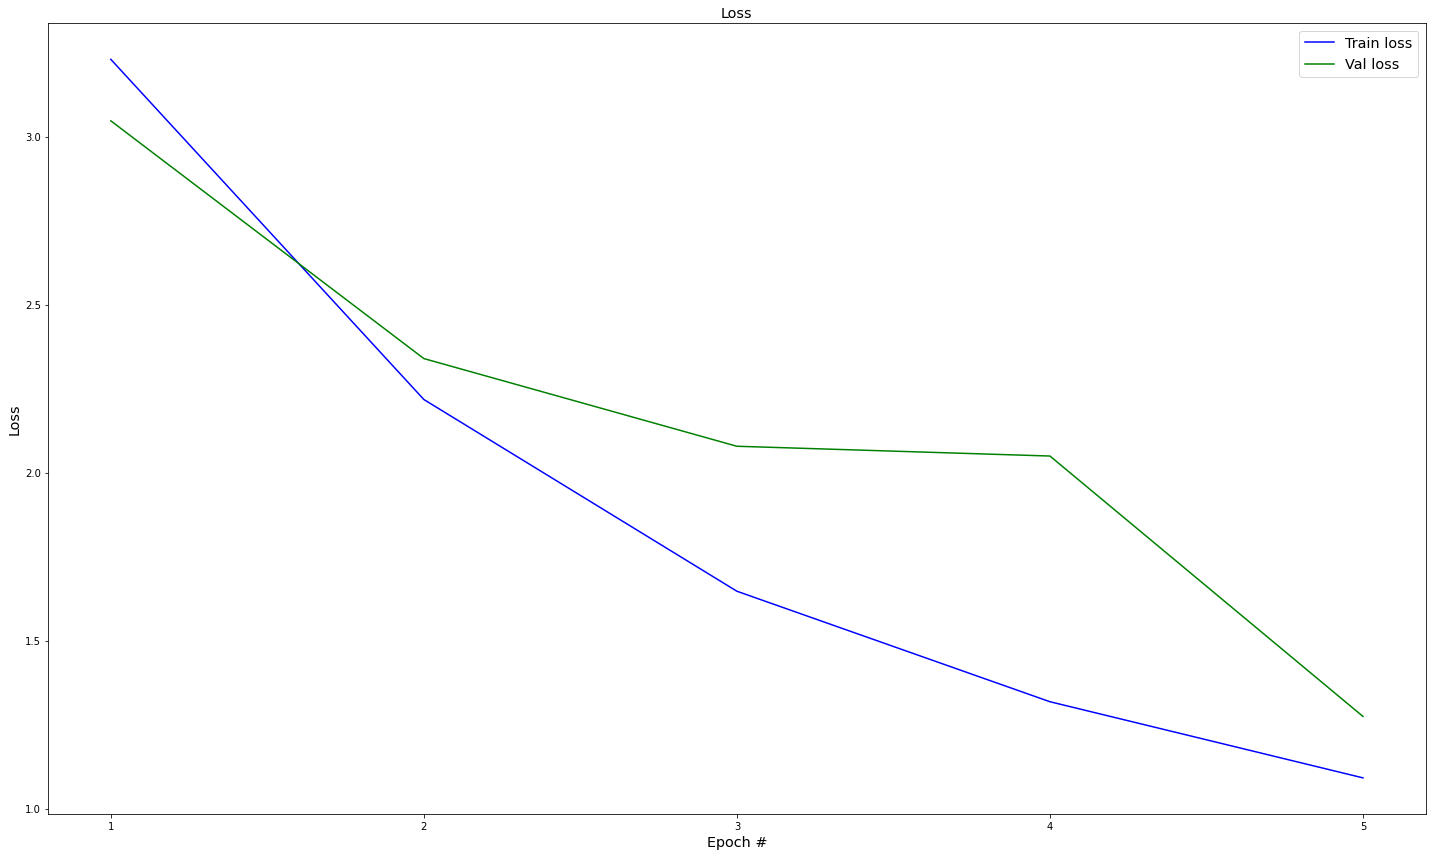

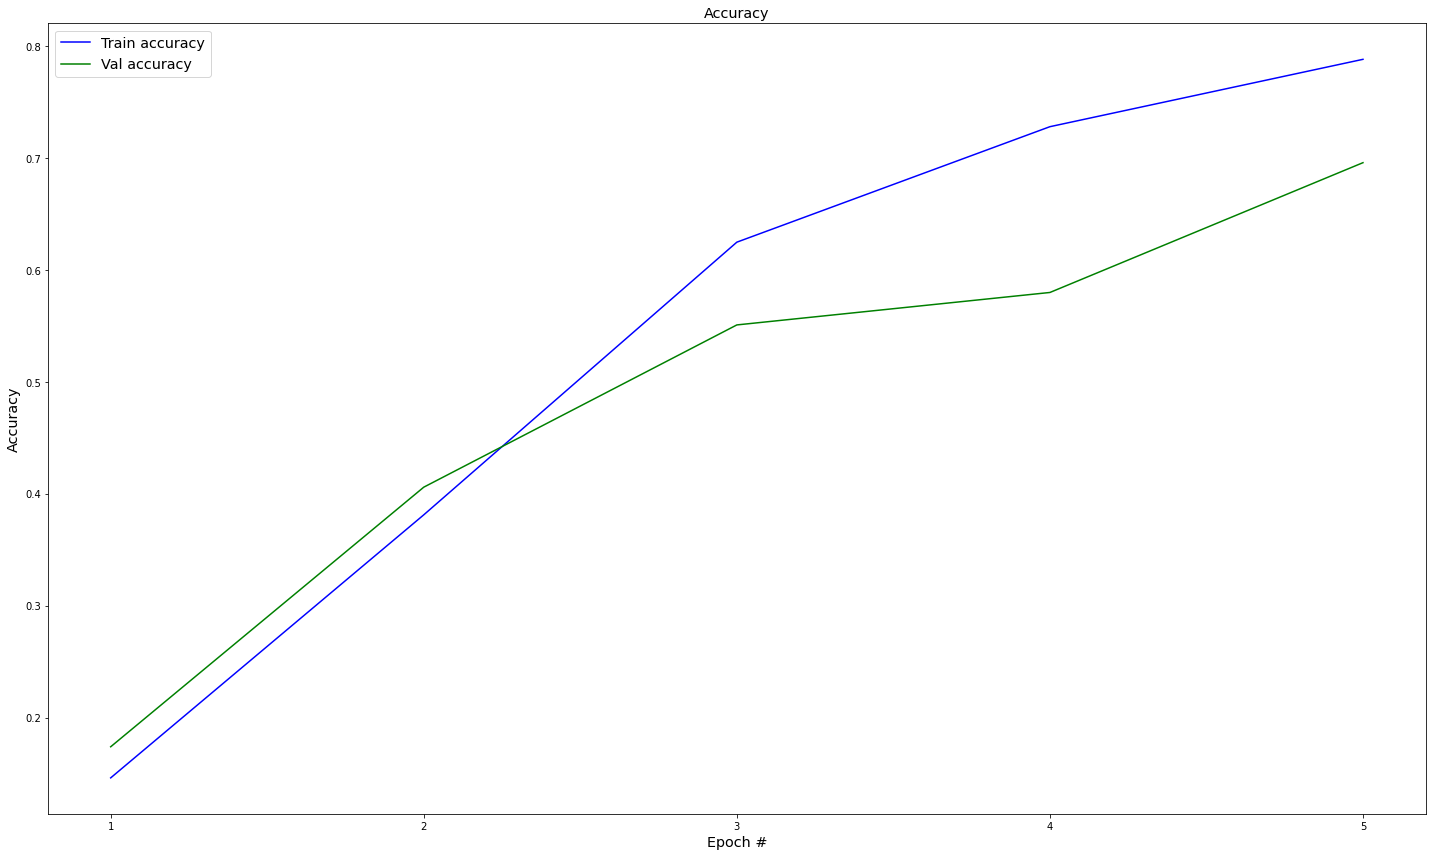

<IPython.core.display.Javascript object>

Sauvegade des images


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
if __name__ == '__main__':
    # Execute program and empty GPU cache
    try:
        stats_qc, trainer_qc, dldrs_qc = main_transfer(trainer_de)
        print("Représentation du traitement des données")
        plot_loss_by_epoch(stats_qc["losses"]["train"], stats_qc["losses"]["val"], prefix="tf")
        plot_accuracy_by_epoch(stats_qc["accuracies"]["train"], stats_qc["accuracies"]["val"], prefix="tf")

        if IS_COLAB_ENV:
            print("Sauvegade des images")
            # Only if in a Google Colab Environment
            for img_name in glob("./tf_*.png"):
                files.download(img_name)
        torch.cuda.empty_cache()
    except BaseException as err:
        torch.cuda.empty_cache()
        raise err

## Test sur réseau de neurones transféré avec données québécoises

In [13]:
def quebec_network_test(trainer, data_loaders):
    """Quebec Network Test

    Process Test with Quebec Model Network
    """
    print("Test du réseau sur les données quebecoises")
    dev = trainer.device
    qc_model = trainer.get_model().to(dev)

    y_pred, y_test = predict(qc_model, data_loaders['test'], dev)
    y_pred = y_pred.float()
    y_test = y_test.float()
    tf_report = precision_recall_fscore_support(y_test, y_pred)

    return tf_report

Test du réseau sur les données quebecoises


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([1.   , 0.625, 0.5  , 0.   , 0.75 , 0.   , 0.25 , 0.   , 0.   ,
       0.   , 1.   , 1.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.75 ,
       1.   , 0.   , 0.   ]),
 array([1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       1., 1., 0., 0.]),
 array([1.        , 0.76923077, 0.66666667, 0.        , 0.85714286,
       0.        , 0.4       , 0.        , 0.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.85714286, 1.        , 0.        ,
       0.        ]),
 array([10,  5,  2,  1,  3,  1,  1,  2,  2,  1,  7,  1,  1,  0,  1,  1,  2,
        3,  2,  1,  1]))
Représentation du traitement des données


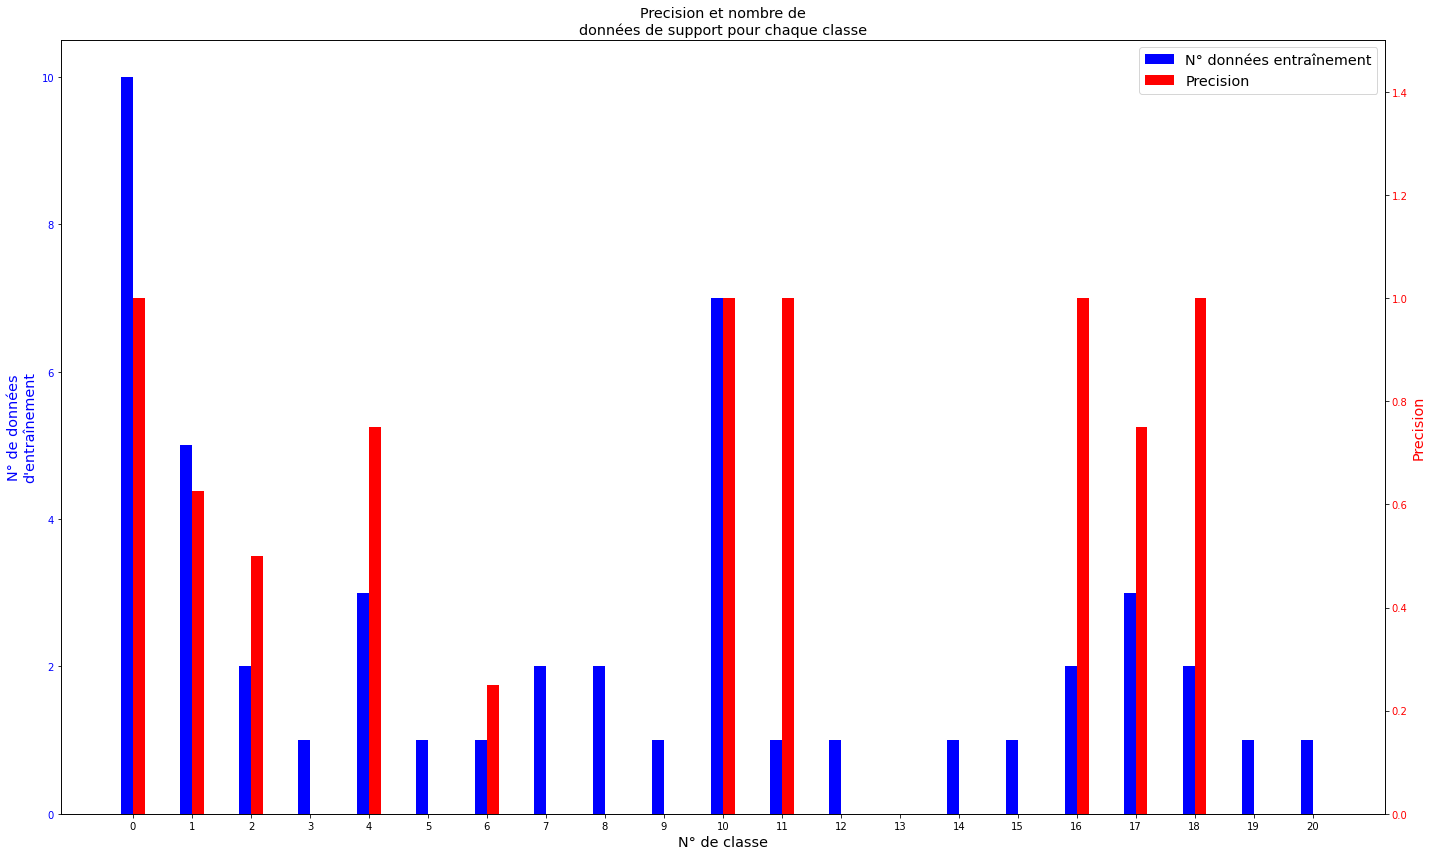

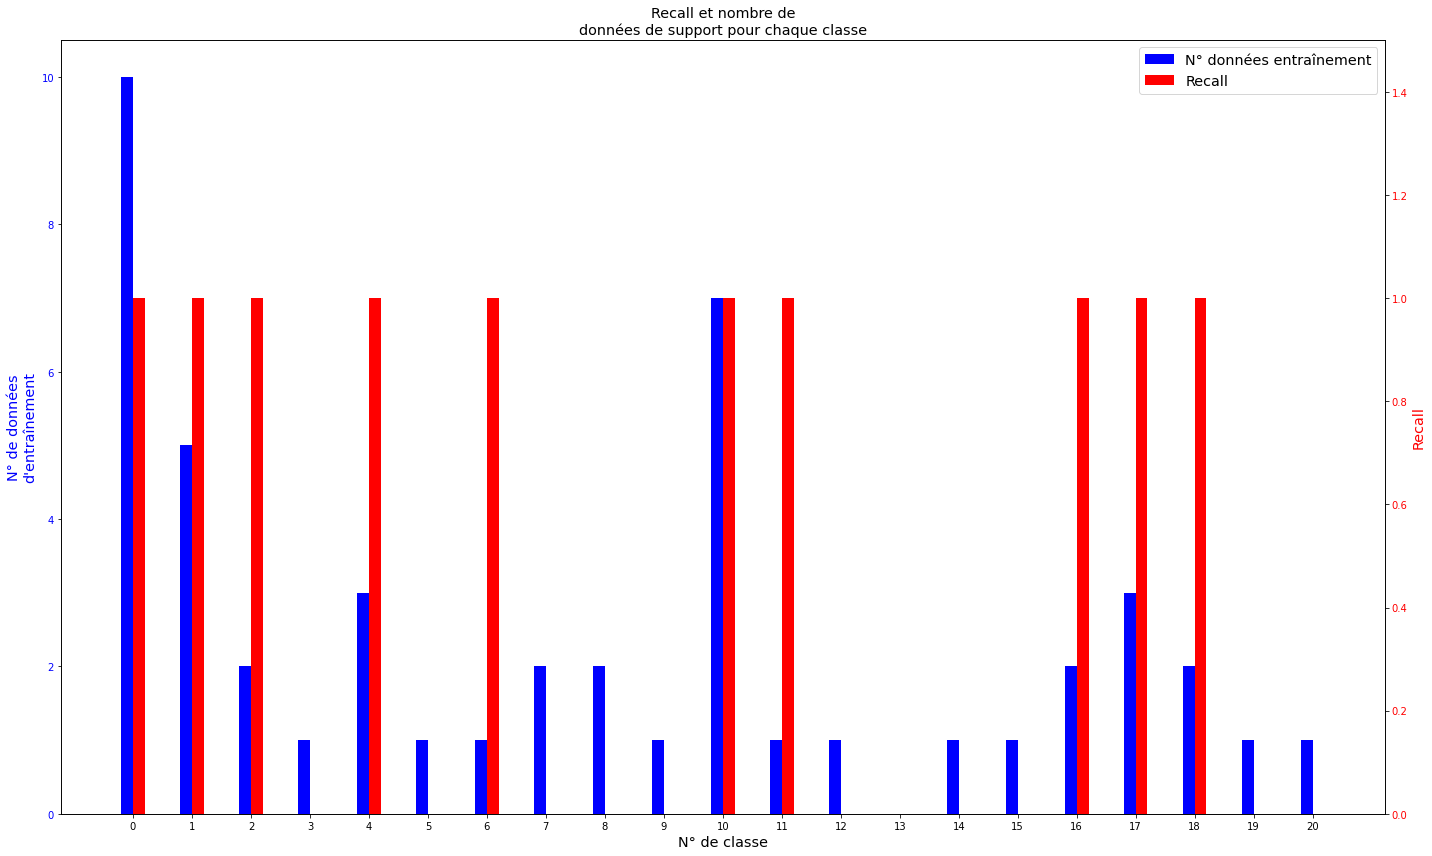

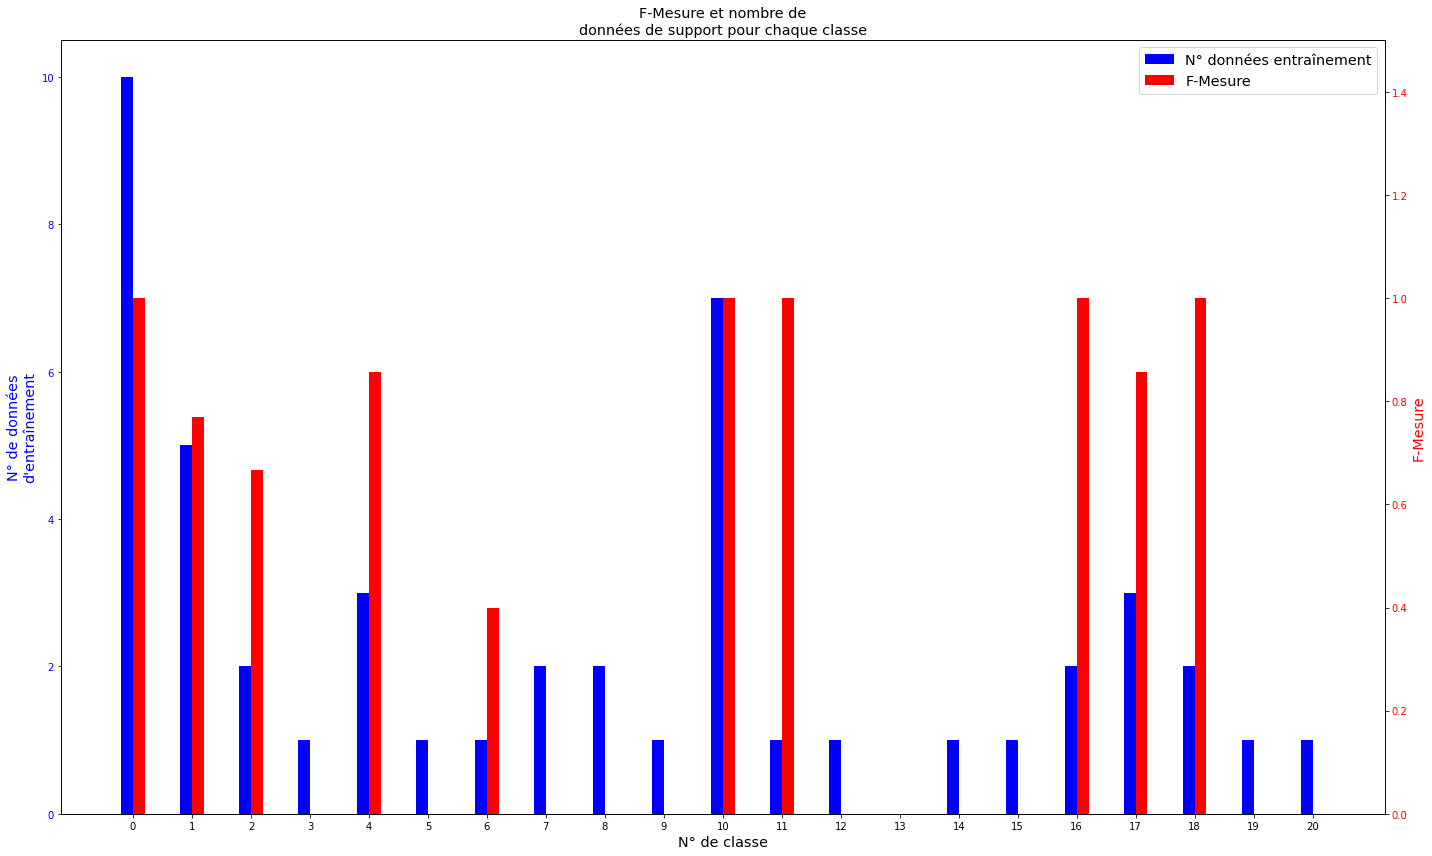

Sauvegarde des images


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
if __name__ == '__main__':
    # Execute program and empty GPU cache
    try:
        tf_report = quebec_network_test(trainer_qc, dldrs_qc)
        print(pformat(tf_report))
        report_vals = {k: v for k, v in zip(("precision", "recall", "f-mesure", "support"), tf_report)}
        print("Représentation du traitement des données")
        for c in ("precision", "recall", "f-mesure"):
            bar_plot_report(report_vals, c, transfer=True)
        if IS_COLAB_ENV:
            print("Sauvegarde des images")
            # Only if in a Google Colab Environment
            for img_name in glob("./tf-*.png"):
                files.download(img_name)
        torch.cuda.empty_cache()
    except BaseException as err:
        torch.cuda.empty_cache()
        raise err